# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb

In [2]:
torch.__version__

'2.2.1+cu121'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed
from base.model.decoder import Decoder
from base.data.dataset import GeneExpressionDataset
from base.engine.train import train_dgd_mrna

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 0
set_seed(seed)

num_workers = 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cpu


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_is.tsv", sep='\t', index_col=[0])
tcga_mrna = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])

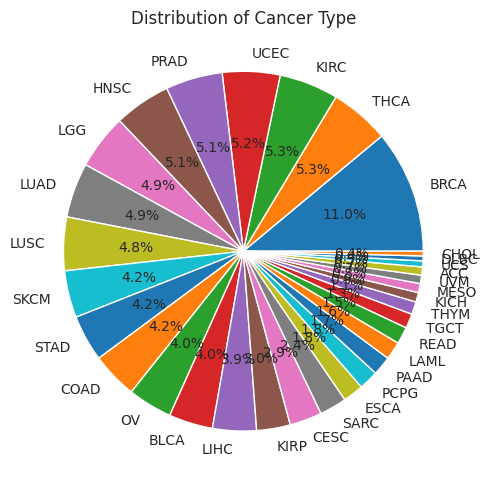

In [6]:
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a pie chart
plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
plt.pie(primary_site_counts['count'], labels=primary_site_counts['cancer_type'], autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Cancer Type')
plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

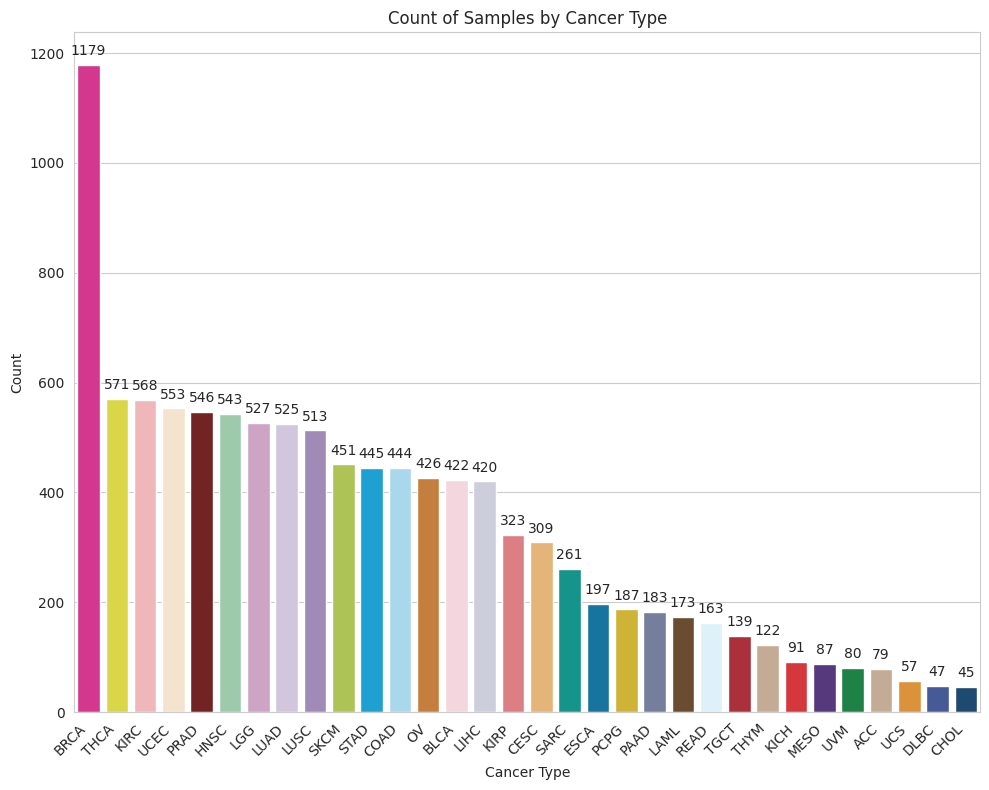

In [7]:
# Create a bar plot
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

## Data Loader

In [8]:
# make data split for train and validation sets
mirna_out_dim = tcga_mrna.shape[1]-2

# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)

In [9]:
# make data split for train and validation sets
train_ratio = 0.8

# Calculate split indices
total_samples = len(tcga_mrna)
train_end = int(train_ratio * total_samples)

# Split the data
train_mrna = tcga_mrna.iloc[:train_end]
val_mrna = tcga_mrna.iloc[train_end:]

# Train, val, and test data loaders
# Default scaling_type = "mean"
train_dataset = GeneExpressionDataset(train_mrna)
validation_dataset = GeneExpressionDataset(train_mrna)

# make data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=num_workers,
                                           pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size=256,
                                                shuffle=True,
                                                num_workers=num_workers,
                                                pin_memory=True)

In [10]:
print(train_mrna.shape)
print(val_mrna.shape)
print(mirna_out_dim)

(8540, 2452)
(2136, 2452)
2450


In [11]:
n_tissues = len(np.unique(train_dataset.label))
n_tissues

32

# Model Setup

In [12]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 256, 256, 512]
reduction_type = "sum" # output loss reduction

In [13]:
# decoder setup

# set up an output module for the miRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mrna_layer = NB_Module(mrna_out_fc, mirna_out_dim, scaling_type="mean")
output_mrna_layer.n_features = mirna_out_dim


# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_mrna_layer]).to(device)


# setup gmm init
gmm_mean_scale = 5.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [14]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

## Training loop

  0%|                                                                                                                                                                                                                                                                                    | 0/1001 [00:00<?, ?it/s]

0 2.2453809623380967 7.612631229874122


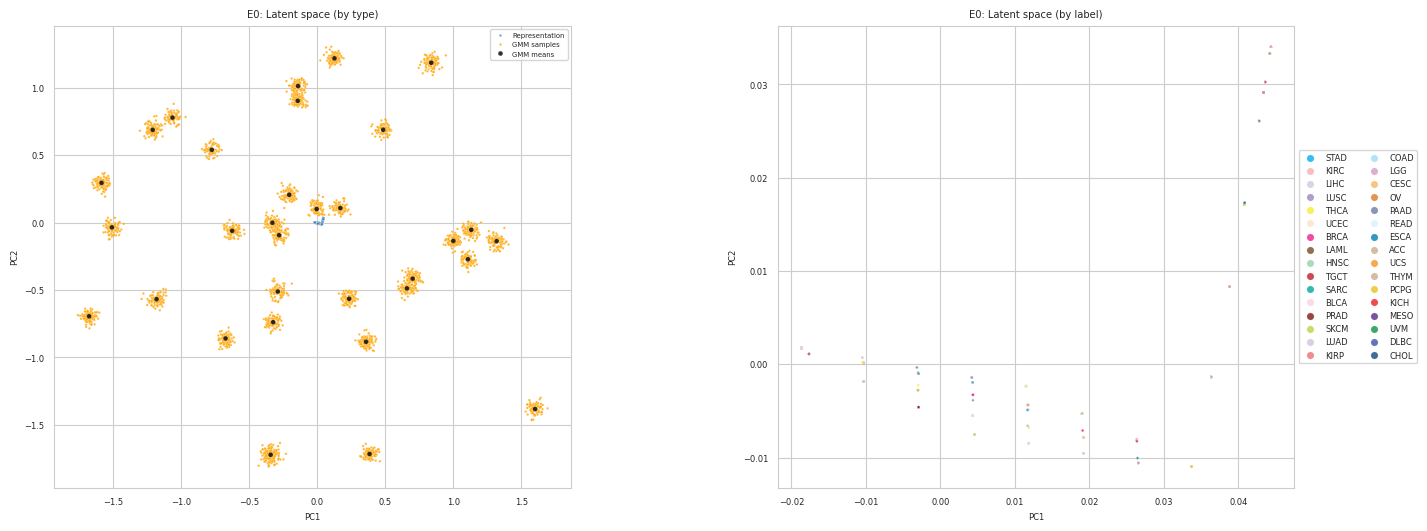

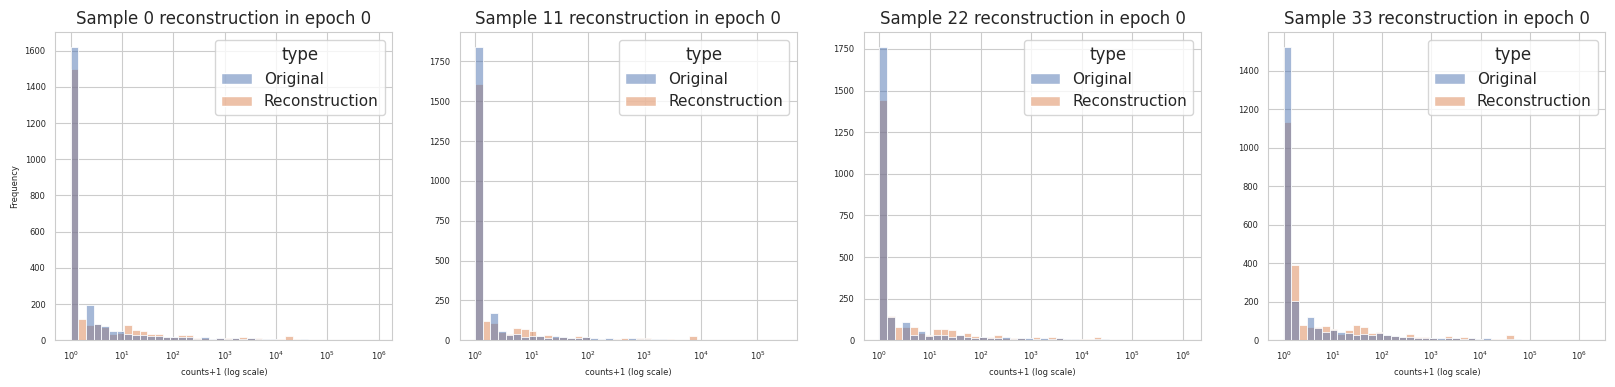

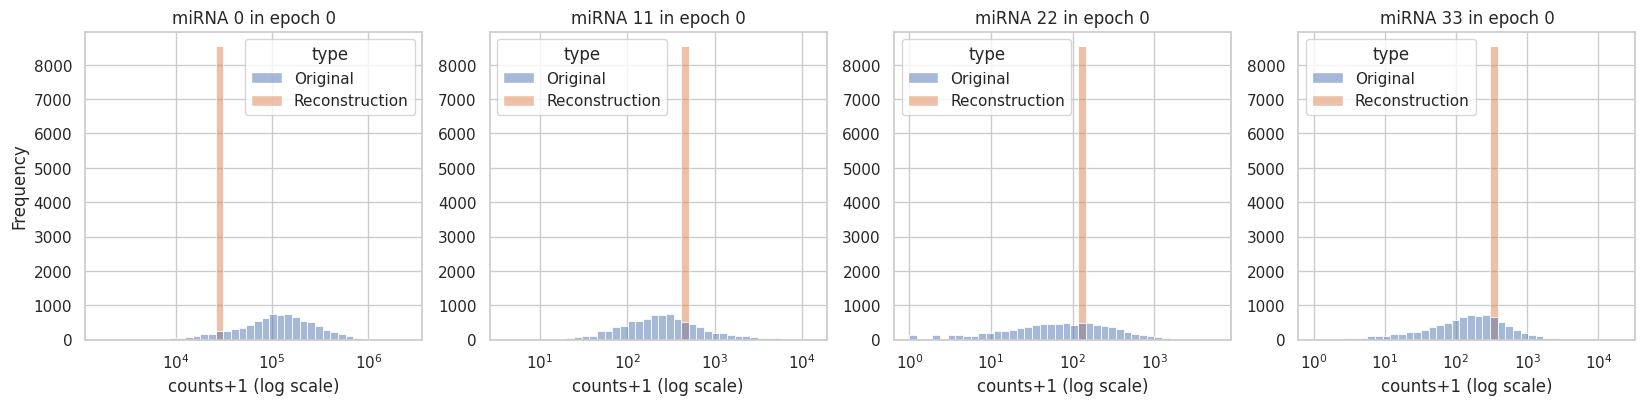

 12%|███████████████████████████████▋                                                                                                                                                                                                                                        | 120/1001 [07:40<1:16:27,  5.21s/it]

In [ ]:
# train for n epochs and plot learning curves

n_epochs = 1001
pr = 200 # how often to print epoch
plot = 200 # how often to print plot

loss_tab = train_dgd_mrna(
        dgd, train_loader, validation_loader, device, 
        learning_rates={'dec':0.005,'rep':0.01,'gmm':0.01},
        weight_decay=0., nepochs=n_epochs, pr=pr,plot=plot, reduction_type=reduction_type
    )

# Plotting

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_rmse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_rmse", data=loss_tab, label="Test")
plt.title("miRNA RMSE")
plt.xlabel("Epoch")
plt.ylabel("miRNA RMSE")

# Display the plots
plt.show()

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Display the plots
plt.show()